In [14]:
# Import relevant libraries
import os
import pandas as pd

from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters, TEMPLATE_TIME_SETUP_DICT

import numpy as np

from SALib.sample import saltelli

from comparative_gsa.sample_input_space import sample_input_space

import json

from ModularCirc import BatchRunner

from comparative_gsa.simulate_data import simulate_data
from comparative_gsa.calculate_output_features import calculate_output_features

from SALib.analyze.sobol import analyze
import matplotlib.pyplot as plt

In [15]:
param_path = '../inputs/parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas.json'
# Get the filename from the path, without extension
param_filename = os.path.splitext(os.path.basename(param_path))[0]

n_samples = 245760

simulation_out_path = f'../outputs/simulations/output_{n_samples}_samples_{param_filename}/'


In [16]:
# Load input_544_samples.csv
input_csv = os.path.join(simulation_out_path, f"input_samples_{n_samples}.csv")
X = pd.read_csv(input_csv)
print("Loaded input samples:", X.shape)

# Load simulation_summary.csv
summary_csv = os.path.join(simulation_out_path, "simulations_summary.csv")
Y = pd.read_csv(summary_csv)
print("Loaded simulation summary:", Y.shape)

Loaded input samples: (245760, 35)
Loaded simulation summary: (245760, 32)


In [17]:
output_feature = "p_la_max"  # Change to any column name in Y
Y_feature = Y[output_feature].values  # .values converts to numpy array.
Y_feature.shape

(245760,)

In [18]:
relevant_columns = ['ao.r',
 'ao.c',
 'art.r',
 'art.c',
 'ven.r',
 'ven.c',
 'av.r',
 'mv.r',
 'la.E_pas',
 'la.E_act',
 'la.k_pas',
 'lv.E_pas',
 'lv.E_act',
 'lv.k_pas']

problem = {
    'num_vars': len(relevant_columns),
    'names': relevant_columns,
    'bounds' : X[relevant_columns].describe().loc[['min', 'max']].T.values
}

In [19]:
# Do the sobol_analyse for GSA
sobol_indices = analyze(problem, Y_feature, calc_second_order=True)

/Users/syonis/project/comparative-gsa/venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [20]:
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis
from autoemulate.core.sensitivity_analysis import _sobol_results_to_df 

In [21]:
results = {
    output_feature: sobol_indices
}

In [22]:
sobol_df = _sobol_results_to_df(results)

In [23]:
# Due to a bug in autoemulate plotting, we must swap ST and S1 rows.

# Get the indices of rows where index == 'ST'
mask_st = sobol_df['index'] == 'ST'
mask_s1 = sobol_df['index'] == 'S1'

# For those rows, change the index to be 'S1'
sobol_df.loc[mask_st, 'index'] = 'S1'

# For those rows, change the index to be 'ST'
sobol_df.loc[mask_s1, 'index'] = 'ST'

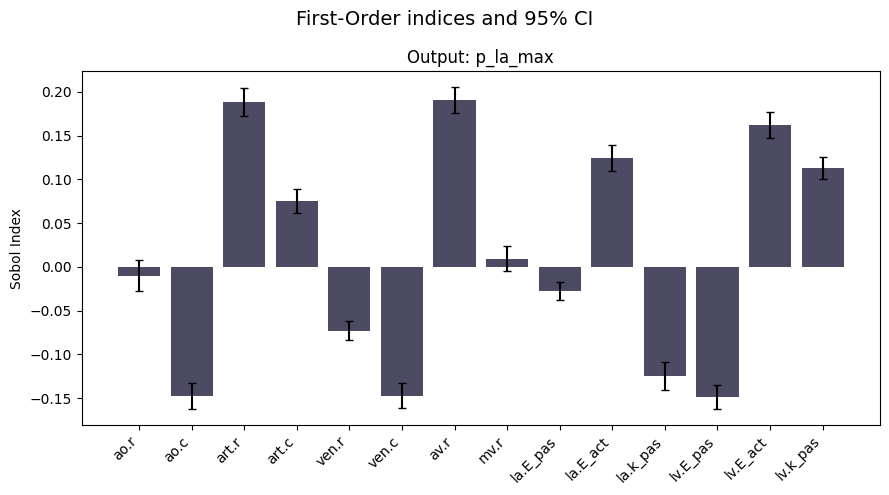

In [24]:
figsize = (9, 5)

SensitivityAnalysis.plot_sobol(sobol_df, index="S1", figsize=figsize) 

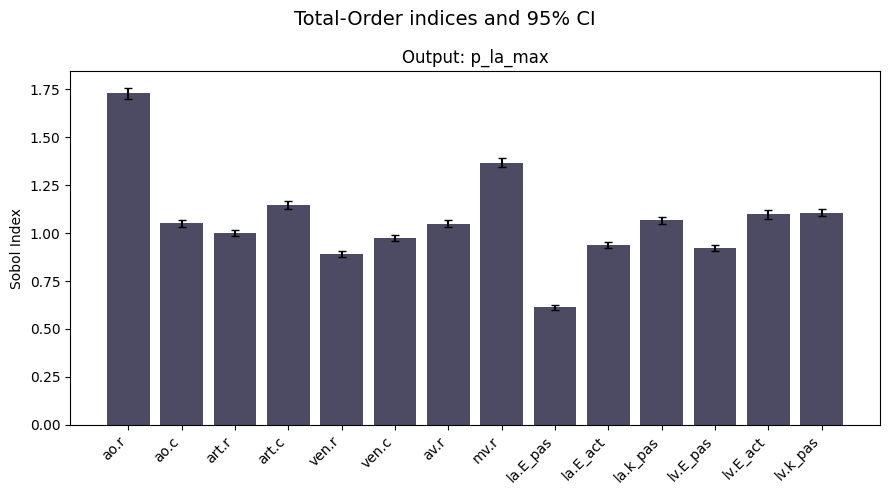

In [25]:
figsize = (9, 5)

SensitivityAnalysis.plot_sobol(sobol_df, index="ST", figsize=figsize) 

In [26]:
# Create directories for saving plots
plots_dir = os.path.join(simulation_out_path, 'plots', f'{output_feature}_{n_samples}_samples')
os.makedirs(plots_dir, exist_ok=True)

figsize = (9, 5)

# Plot and save S1
fig = SensitivityAnalysis.plot_sobol(sobol_df, index="S1", figsize=figsize)
plt.savefig(os.path.join(plots_dir, f'S1_{output_feature}_{n_samples}_samples.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(plots_dir, f'S1_{output_feature}_{n_samples}_samples.pdf'), 
            bbox_inches='tight')
plt.show()

print(f"S1 plot saved to: {plots_dir}")

<Figure size 640x480 with 0 Axes>

S1 plot saved to: ../outputs/simulations/output_245760_samples_parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas/plots/p_la_max_245760_samples


In [27]:
fig = SensitivityAnalysis.plot_sobol(sobol_df, index="ST", figsize=figsize)
plt.savefig(os.path.join(plots_dir, f'ST_{output_feature}_{n_samples}_samples.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(plots_dir, f'ST_{output_feature}_{n_samples}_samples.pdf'), 
            bbox_inches='tight')
plt.show()

print(f"ST plot saved to: {plots_dir}")

<Figure size 640x480 with 0 Axes>

ST plot saved to: ../outputs/simulations/output_245760_samples_parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas/plots/p_la_max_245760_samples
